In [73]:
import pandas as pd
import numpy as np
from datetime import datetime
from scipy import stats
import math

from collections import defaultdict
from math import sqrt

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image

In [74]:
sns.set_style("white")
sns.set_context("paper")

def figsize(fig_width_pt=None, fig_height_pt=None):
    
    if fig_width_pt is None:
        fig_width_pt = 469.755 # Get this from LaTeX using \the\textwidth
        
    inches_per_pt = 1.0/72.27
    fig_width_pt = fig_width_pt*inches_per_pt  # Convert pt to inch

    if fig_height_pt is None:
        golden_mean = (np.sqrt(5)-1.0)/2.0    # Aesthetic ratio
        fig_height_pt = fig_width_pt*golden_mean # height in inches
        
    fig_size = [fig_width_pt,fig_height_pt]
    return fig_size

# Exploration of the data

In [75]:
city_df = pd.read_csv('generated_files/computed_metrics.csv')
city_df = city_df[(city_df.ace != 0)]
city_df.head()

,ace,pro_com,LUM5_single,RNR_nres,nig_rat_daily,hType_mix,hType_mix2,hType_mix3,mdist_nres_daily,ratio_daily_nondaily,...,bld_rat_int,emp_rat_pop,emp_rat_num,bld_rat_area,bor_rat_area,mdist_parks,mdist_smallparks,mdist_railways,mdist_water,mdist_highways
0,1,82053,0.834913,0.720798,0.314583,0.907508,4.370384,2.322173,25.988807,0.377500,...,5.80078,1.437335,0.007092,0.455101,0.000000,1945.604863,221.193580,920.011375,1368.702528,2824.749650
1,5,82053,0.997769,0.896482,0.020000,0.831259,4.737226,2.303030,54.760342,0.181818,...,10.06200,1.963687,0.004797,0.298615,0.131742,2424.571583,436.532829,299.307165,604.726985,2037.927785
2,6,82053,0.671734,0.695502,0.111111,0.899967,4.065773,2.239130,101.339152,0.166667,...,9.09622,6.091624,0.002088,0.234750,0.003436,3526.516135,405.696049,428.644805,911.581690,1339.969963
3,7,82053,0.558117,0.577314,0.000000,0.970021,3.403636,1.941176,100.401111,0.000000,...,10.67450,19.883005,0.000743,0.198219,0.000000,4915.361344,959.766201,846.295364,1125.378636,1173.661382
4,8,82053,0.613831,0.499160,0.100000,0.964111,3.434889,2.130872,253.662195,0.285714,...,4.69656,6.295181,0.000897,0.175623,0.226589,3815.484344,1045.965308,190.534664,1629.066907,463.298247


In [76]:
telco_df = pd.read_csv('generated_files/telco.csv')
telco_df = telco_df[(telco_df.ace != 0)]
telco_df = telco_df[['pro_com', 'ace', 'avg_activity']]
telco_df = pd.merge(city_df[['pro_com', 'ace', 'area_filtr']], telco_df, on =['pro_com', 'ace'])
telco_df['activity_density'] = telco_df['avg_activity'] / telco_df['area_filtr']
del telco_df['avg_activity']
telco_df.head()

,pro_com,ace,area_filtr,activity_density
0,82053,1,2.294074e+06,0.008260
1,82053,5,6.717292e+05,0.008072
2,82053,6,1.583958e+06,0.003594
3,82053,7,1.092818e+06,0.001571
4,82053,8,1.665450e+06,0.002417


In [77]:
city_df['num_intersect']= city_df['num_intersect']/city_df['area_filtr']
city_df['num_community_places']=city_df['num_community_places']/city_df['area_filtr']

city_df['mdist_nres_daily'] = 1./city_df['mdist_nres_daily']
city_df['mdist_parks'] = 1./city_df['mdist_parks']
city_df['mdist_smallparks'] = 1./city_df['mdist_smallparks']
city_df['mdist_railways'] = 1./city_df['mdist_railways']
city_df['mdist_highways'] = 1./city_df['mdist_highways']
city_df['mdist_water'] = 1./city_df['mdist_water']

Convenient names for the features

In [78]:
nomi_sensati_jb = {
    'LUM5_single': 'Single use entropy',
    'mdist_nres_daily': 'Mean dist. nearest daily-use POI',
    'nig_rat_daily': 'Ratio night life places and total POIs',
    'hType_mix2': 'Housing type entropy',
    
    'avg_block_area': 'Average block area',
    'num_intersect': 'Intersections density',
    'num_community_places': 'ratio third places - POIs',
    
    'bld_entr_age': 'Entropy build. age',
    'bld_entr_interiors': 'Entropy build. interiors',
    'enterprises_entr_size': 'Entropy enterprises size',
    'enterprises_empl_size': 'Avg employees per company',
    
    'bld_rat_int': 'ratio internal ap. and num buildings',
    'pop_rat_num': 'ratio num people and area',
    'emp_rat_num': 'Employment density',
    'emp_rat_pop': 'ratio pop density and employment density',
    'bld_rat_area': 'ratio buildings area and total area',
    
    'bor_rat_area': 'ratio vacuums area and total area',
    'mdist_parks': 'Avg distance blocks - parks',
    'mdist_smallparks': 'Avg distance blocks - small parks',
    'mdist_railways': 'Avg distance blocks - railways',
    'mdist_highways': 'Avg distance blocks - highways',
    'mdist_water': 'Avg distance blocks - water',
    
    
    'den_nres_daily': 'den_nres_daily',
    'den_nres_non-daily': 'den_nres_non-daily',
    'bld_std_age': 'bld_std_age'
}

nomi_sensati_mobile = {
    'avg_activity': 'Average activity',
    'avg_activity_day': 'Average activity (daytime)',
    'avg_activity_night': 'Average activity (night-time)',
}

nomi_sensati = {**nomi_sensati_jb, **nomi_sensati_mobile}

## Correlations

In [79]:
from numbers import Number

def compute_stats(feature, corr_df, social_index, social_name, c2):
    spearman = stats.spearmanr(social_index.values, feature.values)
    corr_df.loc[social_name,c2] = as_correlation_value(spearman[0], spearman[1])
    return corr_df

def print_stats_features(df_f_i, corr_df, social_index_i):
    df_f_i = df_f_i.sort_values(['pro_com','ace'])
    social_index_i = social_index_i.sort_values(['pro_com','ace'])
    for c in df_f_i.columns:
        if c not in {'ace', 'pro_com', 'area', 'area_filtr'}:
            for c2 in social_index_i.columns:
                if c2 not in {'ace', 'pro_com', 'area', 'area_filtr'}:
                    corr_df = compute_stats(df_f_i[c], corr_df, social_index_i[c2], nomi_sensati[c], c2)
                    
    return corr_df

def as_correlation_value(v, p_value):  
    if isinstance(v, Number):
        add = ''
        if p_value < 0.01:
            add = '**'
        elif p_value < 0.05:
            add = '*'
        return "{0:.4f}".format(v)+add
    else:
        raise TypeError("Numeric type required")


In [80]:
city_df = city_df[['pro_com', 'ace', 'area_filtr', 'area'] + list(nomi_sensati_jb.keys())]

### 2-way correlations

Legend:
* "*": p-value < 0.05
* "**": p-value < 0.01

In [81]:
corr_df = pd.DataFrame({})
corr_df = print_stats_features(city_df[city_df.pro_com!=27042], corr_df, telco_df[telco_df.pro_com!=27042])
corr_df

,activity_density
Single use entropy,-0.1636**
Mean dist. nearest daily-use POI,0.7042**
Ratio night life places and total POIs,0.2833**
Housing type entropy,0.6506**
Average block area,-0.5296**
Intersections density,0.7038**
ratio third places - POIs,0.7543**
Entropy build. age,-0.4841**
Entropy build. interiors,-0.2911**
Entropy enterprises size,0.1822**


### Milano

In [82]:
some_attributes = ['pro_com', 'ace', 'hType_mix2',
 'mdist_smallparks',
 'num_community_places',
 'num_intersect',
 'pop_rat_num',
 'emp_rat_num',
 'enterprises_empl_size',
 'mdist_highways']

In [83]:
corr_df = pd.DataFrame({})
corr_df = print_stats_features(city_df[city_df.pro_com==15146][some_attributes], corr_df, telco_df[telco_df.pro_com==15146])
corr_df

,activity_density
Housing type entropy,0.6062**
Avg distance blocks - small parks,0.1058
ratio third places - POIs,0.9229**
Intersections density,0.8509**
ratio num people and area,0.6094**
Employment density,0.8839**
Avg employees per company,0.0500
Avg distance blocks - highways,-0.6280**


### Roma

In [84]:
corr_df = pd.DataFrame({})
corr_df = print_stats_features(city_df[(city_df.pro_com==58091)][some_attributes], corr_df, telco_df[(telco_df.pro_com==58091)])
corr_df

,activity_density
Housing type entropy,0.7542**
Avg distance blocks - small parks,0.7825**
ratio third places - POIs,0.8580**
Intersections density,0.7621**
ratio num people and area,0.6065**
Employment density,0.8640**
Avg employees per company,0.2349**
Avg distance blocks - highways,-0.3827**


### Torino

In [85]:
corr_df = pd.DataFrame({})
corr_df = print_stats_features(city_df[(city_df.pro_com==1272)][some_attributes], corr_df, telco_df[(telco_df.pro_com==1272)])
corr_df

,activity_density
Housing type entropy,0.8299**
Avg distance blocks - small parks,0.3960**
ratio third places - POIs,0.8890**
Intersections density,0.7709**
ratio num people and area,0.4677**
Employment density,0.7761**
Avg employees per company,-0.1349
Avg distance blocks - highways,-0.5303**


### Correlations between attributes

In [86]:
parse = lambda x: datetime.datetime.fromtimestamp(float(x)/1000)

collist = city_df.columns.tolist()
collist.remove('ace')
collist.remove('pro_com')
collist.remove('area')
collist.remove('area_filtr')

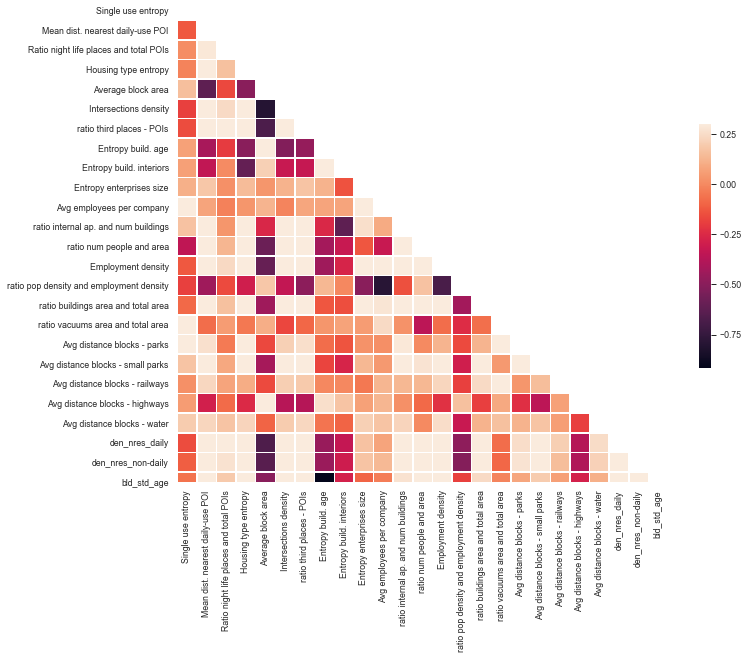

In [87]:
corr = city_df[collist].corr(method='spearman')

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr,mask=mask, vmax=.3,
            square=True, 
            linewidths=.5, cbar_kws={"shrink": .5}, xticklabels=[nomi_sensati[x] for x in corr.columns],
           yticklabels=[nomi_sensati[x] for x in corr.columns])
#plt.savefig('figures/matrix_correlation.pdf', format='pdf', dpi=330,bbox_inches='tight')

## Write dataset

In [88]:
final_df = pd.merge(city_df, telco_df[['pro_com', 'ace', 'activity_density']], on=['ace', 'pro_com'])
final_df.head()

,pro_com,ace,area_filtr,area,LUM5_single,mdist_nres_daily,nig_rat_daily,hType_mix2,avg_block_area,num_intersect,...,bor_rat_area,mdist_parks,mdist_smallparks,mdist_railways,mdist_highways,mdist_water,den_nres_daily,den_nres_non-daily,bld_std_age,activity_density
0,82053,1,2.294074e+06,2526490.0,0.834913,0.038478,0.314583,4.370384,9.041353,0.000462,...,0.000000,0.000514,0.004521,0.001087,0.000354,0.000731,0.000109,0.000066,17.938808,0.008260
1,82053,5,6.717292e+05,841640.0,0.997769,0.018261,0.020000,4.737226,9.349222,0.000194,...,0.131742,0.000412,0.002291,0.003341,0.000491,0.001654,0.000040,0.000009,12.311657,0.008072
2,82053,6,1.583958e+06,1619940.0,0.671734,0.009868,0.111111,4.065773,9.701084,0.000090,...,0.003436,0.000284,0.002465,0.002333,0.000746,0.001097,0.000013,0.000003,10.233967,0.003594
3,82053,7,1.092818e+06,1098970.0,0.558117,0.009960,0.000000,3.403636,9.943522,0.000062,...,0.000000,0.000203,0.001042,0.001182,0.000852,0.000889,0.000008,0.000000,10.451775,0.001571
4,82053,8,1.665450e+06,1665450.0,0.613831,0.003942,0.100000,3.434889,10.437003,0.000028,...,0.226589,0.000262,0.000956,0.005248,0.002158,0.000614,0.000006,0.000002,9.903861,0.002417


In [89]:
final_df.to_csv('generated_files/merged_dataset_lesson.csv', index=False)